Beharrezko importak

In [1]:
from google.colab import files
from imageio import imread
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, Subset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dev eta testeko argazkiak atzitzeko

#Direktorio propioak jarri

In [ ]:
!unzip /content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Datuak_zip/dev.zip -d /content
!unzip /content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Datuak_zip/train.zip -d /content

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/content/train/069574869.jpg  
  inflating: /content/content/train/089344347.jpg  
  inflating: /content/content/train/074307613.jpg  
  inflating: /content/content/train/027067461.jpg  
  inflating: /content/content/train/025276586.jpg  
  inflating: /content/content/train/026481632.jpg  
  inflating: /content/content/train/058793373.jpg  
  inflating: /content/content/train/013516629.jpg  
  inflating: /content/content/train/088274208.jpg  
  inflating: /content/content/train/020226088.jpg  
  inflating: /content/content/train/069532941.jpg  
  inflating: /content/content/train/092247653.jpg  
  inflating: /content/content/train/011009531.jpg  
  inflating: /content/content/train/077396080.jpg  
  inflating: /content/content/train/034104414.jpg  
  inflating: /content/content/train/021546291.jpg  
  inflating: /content/content/train/045405532.jpg  
  inflating: /content/content/train/078409470.jpg  
  i

In [ ]:
import pandas as pd
dev_dataframe = pd.read_csv("/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Datuak_zip/dev.csv")
train_dataframe = pd.read_csv("/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Datuak_zip/train.csv")

Dataset klasea. Dataframe eta argazkien direktorioak erabiliko ditu. Beharrezkoa dataloaderrak datuak lortzeko

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import models, transforms
from imageio import imread

class createDataset(Dataset): #Data set-a
    def __init__(self, dataframe, dir): #Dataframe, transformazioak eta direktorioak gorde
        self.dataframe = dataframe
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.dir = dir
        self.labeltransform = 0

    def __len__(self): #Dataframearen elementu kopurua
        return self.dataframe.shape[0]


    def __getitem__(self, index): #Argazki bat eta bere labelak lortzeko
        image = self.dataframe.iloc[index]["Argazkia"]
        image = imread(self.dir + image)
        luzera = image.shape
        labelx = self.dataframe.iloc[index]["x"]*(self.labeltransform/luzera[1]) #
        labely = self.dataframe.iloc[index]["y"]*(self.labeltransform/luzera[0])
        label = [labelx, labely]
        image = self.transform(image)
        return image , torch.tensor(label, dtype=torch.float) 


In [ ]:
dev_dataset = createDataset(dataframe = dev_dataframe, dir = "/content/content/dev/")
train_dataset = createDataset(dataframe = train_dataframe, dir = "/content/content/train/")

Train loop: eredua epoch baterako entrenatuko du. Dataloader bidez, argazkiak eta bere labelak atiztuko ditu. Iragarpena egin beraien galera konputatu eta  backpropagation egingo du.

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device, normalizazioa):        
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    batch = 0
    for batch, (X, y) in enumerate(dataloader): #Dataloaderretik datuak eta labelak artu
      X = X.to(device)
      y = y.to(device)
      
      # Iragarpena egin eta galera lortu
      pred = model(X)

      loss = loss_fn(pred, y)

      #Bataz besteko errorea kalatzeko
      x = abs(pred[:,0]-y[:,0])
      y = abs(pred[:,1]-y[:,1])
      media = (x+y)/2
      suma = torch.sum(media).item()

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Store galera eta errorea gorde
      train_loss += loss.item()
      train_acc += suma/normalizazioa

      # Aldiro galera erakutsi
      if batch % 10 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      batch +=1
    train_loss /= num_batches
    train_acc /= size
    return train_loss, train_acc

Test loop: datuentzako galera eta bataz besteko errorea kalkulatuko ditu atzeranzko propagazioa egin gabe.

In [ ]:
def test_loop(dataloader, model, loss_fn, device, normalizazioa):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          x = abs(pred[:,0]-y[:,0])
          y = abs(pred[:,1]-y[:,1])
          media = (x+y)/2
          suma = torch.sum(media).item()
          test_acc += suma/normalizazioa
            
    test_loss /= num_batches
    test_acc /= size
    print(f"Test Error: \n Batazbesteko errorea: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_acc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


#Sareen entrenamenduak (hauek gorde nahi badira direktorioak ezarri beharko dira):

ResNet 18 Frozen Model

In [ ]:
model_frozen = torchvision.models.resnet18(weights = 'DEFAULT')
for p in model_frozen.parameters():
  p.requires_grad = False
model_frozen.fc = torch.nn.Linear(512,2)


model_frozen = model_frozen.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#Beharrezko transformazioak
our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(256,256)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 256
train_dataset.transform = our_transforms 
train_dataset.labeltransform = 256

In [ ]:
#Entrenamendua
import time

learning_rate = 1e-3
batch_size = 32
epochs = 10
normalizazioa = 256
# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_frozen.parameters(), lr=learning_rate)

train_losses, train_meanErrors, dev_meanErrors, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_frozen, loss_fn, optimizer, device, normalizazioa)
    print(f'train loss: {train_loss}, mean error: {train_acc}')
    train_losses.append(train_loss)
    train_meanErrors.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_frozen, loss_fn, device, normalizazioa)
    dev_losses.append(dev_loss)
    dev_meanErrors.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_meanErrors)} in epoch {dev_meanErrors.index(max(dev_meanErrors))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 11207.228516  [    0/ 7804]
loss: 11376.284180  [  320/ 7804]
loss: 10334.726562  [  640/ 7804]
loss: 11274.976562  [  960/ 7804]
loss: 8646.072266  [ 1280/ 7804]
loss: 8294.929688  [ 1600/ 7804]
loss: 7036.500977  [ 1920/ 7804]
loss: 6680.619629  [ 2240/ 7804]
loss: 5855.125977  [ 2560/ 7804]
loss: 6941.703613  [ 2880/ 7804]
loss: 5750.775391  [ 3200/ 7804]
loss: 4831.994629  [ 3520/ 7804]
loss: 3724.500488  [ 3840/ 7804]
loss: 4815.433594  [ 4160/ 7804]
loss: 5528.852539  [ 4480/ 7804]
loss: 3151.292480  [ 4800/ 7804]
loss: 3477.262451  [ 5120/ 7804]
loss: 4052.461914  [ 5440/ 7804]
loss: 3541.223145  [ 5760/ 7804]
loss: 1930.820435  [ 6080/ 7804]
loss: 3535.038330  [ 6400/ 7804]
loss: 2564.446289  [ 6720/ 7804]
loss: 2605.499023  [ 7040/ 7804]
loss: 2945.046875  [ 7360/ 7804]
loss: 2067.385986  [ 7680/ 7804]
train loss: 5323.037857806096, mean error: 0.22388262573967585
Test Error: 
 Batazbesteko errorea: 15.2%, Avg loss: 2426.835661 

E

In [ ]:
torch.save(model_frozen.state_dict(), "/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/Resnet18_frozen(lt)")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/dev_meanError', 'w') as f:
    for line in dev_meanErrors:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/train_meanError', 'w') as f:
    for line in train_meanErrors:
        f.write(f"{line}\n")

   e           tl           dl
0  0  5323.037858  2426.835661
1  1  1925.149016  1672.503440
2  2  1669.755159  1631.124261
3  3  1639.066474  1610.881069
4  4  1619.855561  1585.742969
5  5  1597.835933  1567.123521
6  6  1579.107005  1549.418255
7  7  1562.505711  1535.317395
8  8  1547.381793  1521.402064
9  9  1534.651729  1512.073708


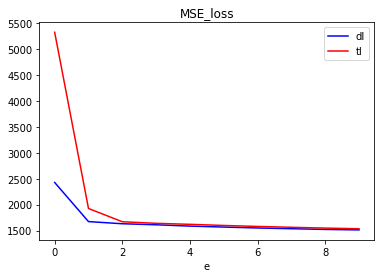

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs)
#repetitions=10
repetitions=10



# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses, "dl":dev_losses}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

   e        tl        dl
0  0  0.223883  0.152282
1  1  0.133169  0.123701
2  2  0.123164  0.121338
3  3  0.121746  0.120202
4  4  0.120673  0.119584
5  5  0.119804  0.118883
6  6  0.118989  0.117957
7  7  0.118415  0.117316
8  8  0.117620  0.116553
9  9  0.117142  0.116082


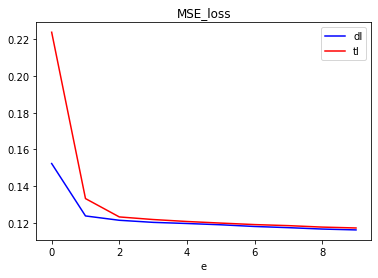

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs)
#repetitions=10
repetitions=10



# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_meanErrors, "dl":dev_meanErrors}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

Dirudienez, ez du konbergitu. Aukera du oraindik dev galera jaisteko. 

Resnet18, aurrekoa + 5 epoch (frozen)

In [ ]:
model_proba = torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/Resnet18_frozen(lt)")

In [ ]:
dev_dataloader = DataLoader(dev_dataset, shuffle=False)
dev_loss, dev_acc = test_loop(dev_dataloader, model_proba, loss_fn, device)

In [ ]:
learning_rate = 1e-3
batch_size = 32
epochs = 5
normalizazioa = 256

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_proba.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_proba, loss_fn, optimizer, device, normalizazioa)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_proba, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

In [ ]:
torch.save(model_frozen.state_dict(), "/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengo + 5)/ResNet18_frozen5(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)")
with open('/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengo + 5)/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengo + 5)/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

In [ ]:
dev_losses_anterior = np.loadtxt("/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)/dev_loss")
train_losses_anterior = np.loadtxt("/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)/train_loss")

     e             tl             dl
0    0  240359.668929  201895.344775
1    1  180433.067463  153227.302126
2    2  138841.760822  118953.033427
3    3  109315.273710   95919.571913
4    4   88996.479396   79300.698899
5    5   75506.811772   69478.158235
6    6   67150.474745   63439.848713
7    7   62313.167512   60456.483094
8    8   59662.874552   58759.819480
9    9   58266.939949   58165.069992
10  10   57906.133661   58023.752658
11  11   57897.429984   57996.650295
12  12   57978.686387   57891.650743
13  13   57836.425797   58183.215228
14  14   57890.435043   57907.909772


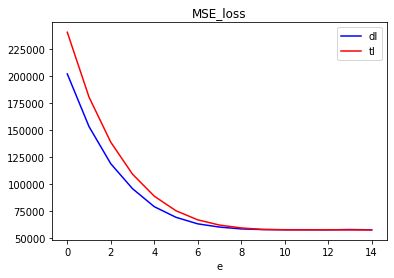

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs+len(train_losses_anterior))
#repetitions=10
repetitions=10

train_losses_entero = np.append(train_losses_anterior, train_losses)
dev_losses_entero = np.append(dev_losses_anterior, dev_losses)

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses_entero, "dl":dev_losses_entero}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

Dirudienez, ez du gaitasunik galera gehiago jaisteko. Sare oso entrenatzen saiatuko gara.

ResNet18 osoa

In [ ]:
model_res18 = torchvision.models.resnet18(weights = 'DEFAULT')

model_res18.fc = torch.nn.Linear(512,2)


model_res18 = model_res18.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Gure transformazioak
our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(256,256)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform=256
train_dataset.transform = our_transforms 
train_dataset.labeltransform=256

In [ ]:
import time

learning_rate = 1e-3
batch_size = 32
epochs = 30
norm = 256

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_res18.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_res18, loss_fn, optimizer, device, norm)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_res18, loss_fn, device, norm)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

In [ ]:
torch.save(model_res18.state_dict(), "/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/resnet18_sinfrozen/ResNet18_NoFrozen(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)")
with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/resnet18_sinfrozen/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/resnet18_sinfrozen/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs)
#repetitions=10
repetitions=10

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses, "dl":dev_losses}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

Resnet50

In [ ]:
model_res50 = torchvision.models.resnet50(weights = 'DEFAULT')

model_res50.fc = torch.nn.Linear(2048,2)

model_res50 = model_res50.to(device)

print(type(model_res50))

<class 'torchvision.models.resnet.ResNet'>


In [ ]:
our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(232,232)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])


dev_dataset.transform = our_transforms 
train_dataset.transform = our_transforms 

In [ ]:
import time

learning_rate = 1e-3
batch_size = 32
epochs = 20

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_res50.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_res50, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_res50, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 347666.218750  [    0/ 7804]
loss: 357418.687500  [  320/ 7804]
loss: 260282.203125  [  640/ 7804]
loss: 261233.906250  [  960/ 7804]
loss: 271853.406250  [ 1280/ 7804]
loss: 181945.546875  [ 1600/ 7804]
loss: 143303.921875  [ 1920/ 7804]
loss: 118658.250000  [ 2240/ 7804]
loss: 129995.023438  [ 2560/ 7804]
loss: 163027.140625  [ 2880/ 7804]
loss: 132349.359375  [ 3200/ 7804]
loss: 98549.140625  [ 3520/ 7804]
loss: 55653.679688  [ 3840/ 7804]
loss: 127106.101562  [ 4160/ 7804]
loss: 143632.343750  [ 4480/ 7804]
loss: 76950.578125  [ 4800/ 7804]
loss: 95905.390625  [ 5120/ 7804]
loss: 106375.734375  [ 5440/ 7804]
loss: 75742.226562  [ 5760/ 7804]
loss: 35841.875000  [ 6080/ 7804]
loss: 84379.375000  [ 6400/ 7804]
loss: 66156.250000  [ 6720/ 7804]
loss: 55813.671875  [ 7040/ 7804]
loss: 76750.109375  [ 7360/ 7804]
loss: 63088.847656  [ 7680/ 7804]
train loss: 124928.66852907275, train_acc: 0.0
Test Error: 
 Accuracy: 0.0%, Avg loss: 73961.920

In [ ]:
torch.save(model_res50.state_dict(), "/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/ResNet50(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)")
with open('/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

     e             tl            dl
0    0  124928.668529  73961.920594
1    1   57550.051270  57047.197074
2    2   49988.205206  51546.143923
3    3   49026.975170  48584.144403
4    4   44406.320288  48433.964171
5    5   42700.726603  41316.517066
6    6   38965.482926  38099.490699
7    7   37027.941522  54460.656762
8    8   35093.590804  37854.419874
9    9   32904.269123  36385.541640
10  10   29949.053119  44481.821017
11  11   28052.389488  32611.718414
12  12   26282.914927  30827.781154
13  13   24832.455618  27255.904713
14  14   22142.514756  29356.076940
15  15   20270.359537  27637.207447
16  16   17611.531400  31530.924020
17  17   16012.467587  24425.962875
18  18   14074.363669  34718.603932
19  19   12235.221452  46190.933370


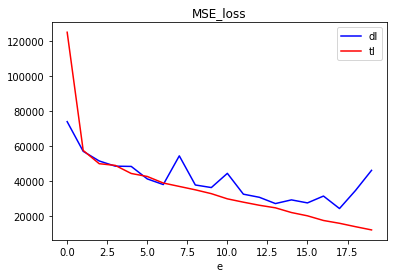

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs)
#repetitions=10
repetitions=10

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses, "dl":dev_losses}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

ResNet50 gehiago

In [ ]:
model_res50_g = torchvision.models.resnet50(weights = 'DEFAULT')

model_res50_g.fc = torch.nn.Linear(2048,2)

model_res50_g = model_res50_g.to(device)

model_res50_g.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/ResNet50(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)"))


In [ ]:
our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(232,232)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])
 
dev_dataset.transform = our_transforms 
train_dataset.transform = our_transforms 

In [ ]:
import time

learning_rate = 1e-3
batch_size = 32
epochs = 10

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_res50_g.parameters(), lr=learning_rate)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_res50_g, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_res50_g, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 8980.042969  [    0/ 7804]
loss: 30890.501953  [  320/ 7804]
loss: 8972.378906  [  640/ 7804]
loss: 11276.828125  [  960/ 7804]
loss: 15332.636719  [ 1280/ 7804]
loss: 13541.066406  [ 1600/ 7804]
loss: 7138.026367  [ 1920/ 7804]
loss: 5610.750977  [ 2240/ 7804]
loss: 8535.700195  [ 2560/ 7804]
loss: 19952.785156  [ 2880/ 7804]
loss: 12731.820312  [ 3200/ 7804]
loss: 15174.006836  [ 3520/ 7804]
loss: 14882.458984  [ 3840/ 7804]
loss: 20724.857422  [ 4160/ 7804]
loss: 20754.957031  [ 4480/ 7804]
loss: 14083.554688  [ 4800/ 7804]
loss: 11694.755859  [ 5120/ 7804]
loss: 15807.480469  [ 5440/ 7804]
loss: 9271.875000  [ 5760/ 7804]
loss: 26300.015625  [ 6080/ 7804]
loss: 13618.772461  [ 6400/ 7804]
loss: 13133.639648  [ 6720/ 7804]
loss: 8686.763672  [ 7040/ 7804]
loss: 14642.118164  [ 7360/ 7804]
loss: 10491.487305  [ 7680/ 7804]
train loss: 13027.861184042009, train_acc: 0.0
Test Error: 
 Accuracy: 0.0%, Avg loss: 36865.179880 

Epoch 2
-------

In [ ]:
torch.save(model_res50_g.state_dict(), "/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo + 10)/ResNet50_gehiago(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)")
with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo + 10)/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo + 10)/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

In [ ]:
dev_losses_anterior = np.loadtxt("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/dev_loss")
train_losses_anterior = np.loadtxt("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/train_loss")

     e             tl            dl
0    0  124928.668529  73961.920594
1    1   57550.051270  57047.197074
2    2   49988.205206  51546.143923
3    3   49026.975170  48584.144403
4    4   44406.320288  48433.964171
5    5   42700.726603  41316.517066
6    6   38965.482926  38099.490699
7    7   37027.941522  54460.656762
8    8   35093.590804  37854.419874
9    9   32904.269123  36385.541640
10  10   29949.053119  44481.821017
11  11   28052.389488  32611.718414
12  12   26282.914927  30827.781154
13  13   24832.455618  27255.904713
14  14   22142.514756  29356.076940
15  15   20270.359537  27637.207447
16  16   17611.531400  31530.924020
17  17   16012.467587  24425.962875
18  18   14074.363669  34718.603932
19  19   12235.221452  46190.933370
20  20   13027.861184  36865.179880
21  21   10821.303255  28464.876393
22  22   10172.349400  28939.071641
23  23    8649.693138  39366.712827
24  24    7491.966085  23376.650775
25  25    6940.767089  35903.897253
26  26    5938.377854  29493

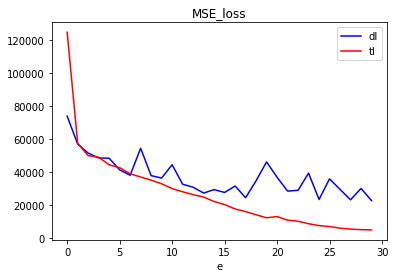

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs+len(train_losses_anterior))
#repetitions=10
repetitions=10

train_losses_entero = np.append(train_losses_anterior, train_losses)
dev_losses_entero = np.append(dev_losses_anterior, dev_losses)

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses_entero, "dl":dev_losses_entero}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

VisionTransformer

In [ ]:
model_vision = torchvision.models.vit_l_32(weights = 'DEFAULT')
model_vision.heads.head = torch.nn.Linear(1024,2)
model_vision = model_vision.to(device)
print(model_vision)

Downloading: "https://download.pytorch.org/models/vit_l_32-c7638314.pth" to /root/.cache/torch/hub/checkpoints/vit_l_32-c7638314.pth


  0%|          | 0.00/1.14G [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [ ]:
our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(224,224)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 224
train_dataset.transform = our_transforms 
train_dataset.labeltransform = 224

In [ ]:
import time

learning_rate = 1e-3
batch_size = 32
epochs = 15
normalizazioa = 224

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_vision.parameters(), lr=learning_rate)

train_losses, train_meanErrors, dev_meanErrors, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_vision, loss_fn, optimizer, device, normalizazioa)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_meanErrors.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_vision, loss_fn, device, normalizazioa)
    dev_losses.append(dev_loss)
    dev_meanErrors.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_meanErrors)} in epoch {dev_meanErrors.index(max(dev_meanErrors))+1}')
print(f'Training time: {end-start}')

NameError: ignored

In [ ]:
torch.save(model_vision.state_dict(), "/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/Vision Transformer(lt)/Vision_Transformer(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)(lt)")
with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/Vision Transformer(lt)/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/Vision Transformer(lt)/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/Vision Transformer(lt)/dev_meanError', 'w') as f:
    for line in dev_meanErrors:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/Vision Transformer(lt)/train_meanError', 'w') as f:
    for line in train_meanErrors:
        f.write(f"{line}\n")

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs)
#repetitions=10
repetitions=10

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses, "dl":dev_losses}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

Regularization (Weight decay ResNet50)

In [ ]:
model_res50_wd = torchvision.models.resnet50(weights = 'DEFAULT')

model_res50_wd.fc = torch.nn.Linear(2048,2)

model_res50_wd = model_res50_wd.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(232,232)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
train_dataset.transform = our_transforms 

In [ ]:
import time

learning_rate = 1e-3
batch_size = 32
epochs = 15
weight_decay = 1e-3

# For reproducibility
torch.manual_seed(0)

# Create train and dev dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_res50_wd.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses, train_accuracies, dev_accuracies, dev_losses  = [], [], [], []
start = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_dataloader, model_res50_wd, loss_fn, optimizer, device)
    print(f'train loss: {train_loss}, train_acc: {train_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    dev_loss, dev_acc = test_loop(dev_dataloader, model_res50_wd, loss_fn, device)
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)    
end = time.time()
print("Done!")

print(f'Best dev accuracy: {max(dev_accuracies)} in epoch {dev_accuracies.index(max(dev_accuracies))+1}')
print(f'Training time: {end-start}')

Epoch 1
-------------------------------
loss: 347665.937500  [    0/ 7804]
loss: 357605.125000  [  320/ 7804]
loss: 275533.625000  [  640/ 7804]
loss: 260108.156250  [  960/ 7804]
loss: 291996.750000  [ 1280/ 7804]
loss: 178709.718750  [ 1600/ 7804]
loss: 156093.390625  [ 1920/ 7804]
loss: 134495.031250  [ 2240/ 7804]
loss: 142583.625000  [ 2560/ 7804]
loss: 179545.093750  [ 2880/ 7804]
loss: 143709.203125  [ 3200/ 7804]
loss: 102551.664062  [ 3520/ 7804]
loss: 66125.343750  [ 3840/ 7804]
loss: 141381.640625  [ 4160/ 7804]
loss: 137367.093750  [ 4480/ 7804]
loss: 72086.140625  [ 4800/ 7804]
loss: 99523.953125  [ 5120/ 7804]
loss: 119495.953125  [ 5440/ 7804]
loss: 87152.828125  [ 5760/ 7804]
loss: 52195.054688  [ 6080/ 7804]
loss: 102220.390625  [ 6400/ 7804]
loss: 76148.843750  [ 6720/ 7804]
loss: 65457.660156  [ 7040/ 7804]
loss: 74926.312500  [ 7360/ 7804]
loss: 40332.890625  [ 7680/ 7804]
train loss: 134326.59386206456, train_acc: 0.0
Test Error: 
 Accuracy: 0.0%, Avg loss: 61938.2

In [ ]:
torch.save(model_res50_wd.state_dict(), "/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(WD)/ResNet50_WD(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)_WD(1e-3)")
with open('/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(WD)/dev_loss', 'w') as f:
    for line in dev_losses:
        f.write(f"{line}\n")

with open('/content/drive/MyDrive/AA3/IANS/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(WD)/train_loss', 'w') as f:
    for line in train_losses:
        f.write(f"{line}\n")

     e             tl            dl
0    0  134326.593862  61938.228708
1    1   59476.145252  57461.610272
2    2   55644.965452  54489.744973
3    3   50625.287374  51817.710041
4    4   45982.358046  45436.932953
5    5   41971.920818  39821.926950
6    6   37879.851434  39009.398117
7    7   35735.535364  40117.907147
8    8   33460.806260  34161.584257
9    9   30237.298760  32814.638928
10  10   28691.291212  31244.937676
11  11   25797.221732  40994.223969
12  12   24479.869369  39614.634990
13  13   22516.447570  34434.358799
14  14   20146.976026  32013.782803


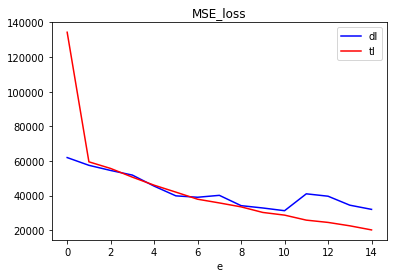

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

epoch_list = np.arange(epochs)
#repetitions=10
repetitions=10

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"tl":train_losses, "dl":dev_losses}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dl', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='tl', color='red', ax=ax,title='MSE_loss')
plt.show()

Test loop 2: Aurreko test loopa bezala baina iragarpenak bueltatuta emaitzak ikusteko  

In [ ]:
def test_loop2(dataloader, model, loss_fn, device, normalizazioa):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc = 0, 0
    pred_x = []
    pred_y = []

    with torch.no_grad():
        for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          pred = model(X)
          test_loss += loss_fn(pred, y).item()
          x = abs(pred[:,0]-y[:,0])
          y = abs(pred[:,1]-y[:,1])
          media = (x+y)/2
          suma = torch.sum(media).item()
          test_acc += suma/normalizazioa
          for i in range(pred.size(0)):
            pred_x.append(pred[i,0].item())
            pred_y.append(pred[i,1].item())

            
    test_loss /= num_batches
    test_acc /= size
    print(f"Test Error: \n Batazbesteko errorea: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_acc, pred_x, pred_y

#Test emaitzak ikusteko

In [ ]:
!unzip /content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Datuak_zip/test.zip -d /content
test_dataframe = pd.read_csv("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/DatuakPose/buru_bat_anotatuak/test.csv")
test_dataset = createDataset(dataframe = test_dataframe, dir = "/content/content/test/")

Archive:  /content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Datuak_zip/test.zip
   creating: /content/content/test/
  inflating: /content/content/test/030430759.jpg  
  inflating: /content/content/test/098933329.jpg  
  inflating: /content/content/test/061259281.jpg  
  inflating: /content/content/test/056540339.jpg  
  inflating: /content/content/test/062112260.jpg  
  inflating: /content/content/test/011027673.jpg  
  inflating: /content/content/test/015031062.jpg  
  inflating: /content/content/test/062013260.jpg  
  inflating: /content/content/test/035949115.jpg  
  inflating: /content/content/test/026245630.jpg  
  inflating: /content/content/test/017258579.jpg  
  inflating: /content/content/test/031075661.jpg  
  inflating: /content/content/test/016110002.jpg  
  inflating: /content/content/test/059115500.jpg  
  inflating: /content/content/test/079665837.jpg  
  inflating: /content/content/test/057337679.jpg  
  inflating: /content/content/test/028943952.jpg  
  inflating: /

ResNet18 frozen

In [ ]:
model_frozen = torchvision.models.resnet18(weights = 'DEFAULT')
for p in model_frozen.parameters():
  p.requires_grad = False
model_frozen.fc = torch.nn.Linear(512,2)

model_frozen = model_frozen.to(device)
model_frozen.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/Resnet18_frozen(lt)"))

our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(256,256)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 256
test_dataset.transform = our_transforms 
test_dataset.labeltransform = 256

loss_fn = nn.MSELoss()
normalizazioa = 256
batch_size = 32

dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dev_loss, dev_acc, dev_x, dev_y = test_loop2(dev_dataloader, model_frozen, loss_fn, device, normalizazioa)
test_loss, test_acc, test_x, test_y = test_loop2(test_dataloader, model_frozen, loss_fn, device, normalizazioa)
print(dev_loss, dev_acc)
print(test_loss, test_acc)

Test Error: 
 Batazbesteko errorea: 11.6%, Avg loss: 1512.073708 

Test Error: 
 Batazbesteko errorea: 11.8%, Avg loss: 1589.892663 

1512.0737084560708 0.11608167640009864
1589.8926629400873 0.1183570606298134


10
   e   train_loss     dev_loss
0  0  5323.037858  2426.835661
1  1  1925.149016  1672.503440
2  2  1669.755159  1631.124261
3  3  1639.066474  1610.881069
4  4  1619.855561  1585.742969
5  5  1597.835933  1567.123521
6  6  1579.107005  1549.418255
7  7  1562.505711  1535.317395
8  8  1547.381793  1521.402064
9  9  1534.651729  1512.073708


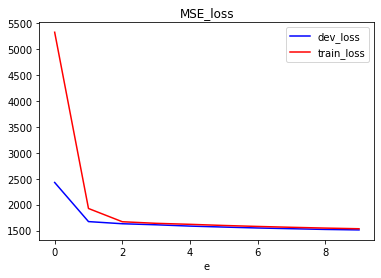

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

dev_losses_anterior = np.loadtxt("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/dev_loss")
train_losses_anterior = np.loadtxt("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/train_loss")
print(len(dev_losses_anterior))
epoch_list = np.arange(10)
#repetitions=10
repetitions=10

train_losses_entero = train_losses_anterior
dev_losses_entero = dev_losses_anterior

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"train_loss":train_losses_entero, "dev_loss":dev_losses_entero}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dev_loss', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='train_loss', color='red', ax=ax,title='MSE_loss')
plt.show()

10
   e  train mean error  dev mean error
0  0          0.223883        0.152282
1  1          0.133169        0.123701
2  2          0.123164        0.121338
3  3          0.121746        0.120202
4  4          0.120673        0.119584
5  5          0.119804        0.118883
6  6          0.118989        0.117957
7  7          0.118415        0.117316
8  8          0.117620        0.116553
9  9          0.117142        0.116082


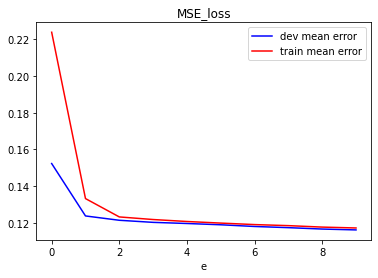

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

dev_losses_anterior = np.loadtxt("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/dev_meanError")
train_losses_anterior = np.loadtxt("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet18(Lehenengoa)(lt)/train_meanError")
print(len(dev_losses_anterior))
epoch_list = np.arange(10)
#repetitions=10
repetitions=10

train_losses_entero = train_losses_anterior
dev_losses_entero = dev_losses_anterior

# Datuak gordetzeko egitura
datuak = pd.DataFrame({"e":epoch_list,"train mean error":train_losses_entero, "dev mean error":dev_losses_entero}) 
print(datuak)

#Irudikatu emaitzak plot batean.
ax = plt.gca()
datuak.plot(kind='line',x='e',y='dev mean error', color='blue', ax=ax)
datuak.plot(kind='line',x='e',y='train mean error', color='red', ax=ax,title='MSE_loss')
plt.show()

ResNet 18

In [ ]:
model_frozen = torchvision.models.resnet18(weights = 'DEFAULT')
model_frozen.fc = torch.nn.Linear(512,2)

model_frozen = model_frozen.to(device)
model_frozen.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/resnet18_osoa/Resnet18_osoa"))

our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(256,256)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 256
test_dataset.transform = our_transforms 
test_dataset.labeltransform = 256

loss_fn = nn.MSELoss()
normalizazioa = 256
batch_size = 32

dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dev_loss, dev_acc, dev_x, dev_y = test_loop2(dev_dataloader, model_frozen, loss_fn, device, normalizazioa)
test_loss, test_acc, test_x, test_y = test_loop2(test_dataloader, model_frozen, loss_fn, device, normalizazioa)
print(dev_loss, dev_acc)
print(test_loss, test_acc)

Test Error: 
 Batazbesteko errorea: 5.5%, Avg loss: 492.931735 

Test Error: 
 Batazbesteko errorea: 5.7%, Avg loss: 581.024071 

492.9317349293193 0.054905886166408416
581.0240708388292 0.057229061827796406


ResNet50

In [ ]:
model_res50.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo)/ResNet50(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)"))

In [ ]:
model_res50_g = torchvision.models.resnet50(weights = 'DEFAULT')
model_res50_g.fc = torch.nn.Linear(2048,2)
model_res50_g = model_res50_g.to(device)
model_res50_g.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/ResNet50(Lehenengo + 10)(lt)/ResNet50_gehiago(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)(lt)"))

our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(232,232)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 232
test_dataset.transform = our_transforms 
test_dataset.labeltransform = 232

loss_fn = nn.MSELoss()
normalizazioa = 232
batch_size = 32

dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dev_loss, dev_acc, dev_x, dev_y = test_loop2(dev_dataloader, model_res50_g, loss_fn, device, normalizazioa)
test_loss, test_acc, test_x, test_y = test_loop2(test_dataloader, model_res50_g, loss_fn, device, normalizazioa)
print(dev_loss, dev_acc)
print(test_loss, test_acc)

Test Error: 
 Batazbesteko errorea: 4.2%, Avg loss: 346.170904 

Test Error: 
 Batazbesteko errorea: 4.3%, Avg loss: 399.450183 

346.170904440958 0.04155811261429903
399.45018272895317 0.04326716446485677


In [ ]:

model_vision = torchvision.models.vit_l_32(weights = 'DEFAULT')
model_vision.heads.head = torch.nn.Linear(1024,2)
model_vision = model_vision.to(device)
model_vision.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/Vision Transformer(lt)/Vision_Transformer(Konboluzioa)_lr(1e-3)_bs(32)_ep(10)(lt)"))


our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(224,224)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 224
test_dataset.transform = our_transforms 
test_dataset.labeltransform = 224

loss_fn = nn.MSELoss()
#optimizer = torch.optim.Adam(model_vision.parameters(), lr=learning_rate)
normalizazioa = 224
batch_size = 32

dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#dev_loss, dev_acc = test_loop(dev_dataloader, model_vision, loss_fn, device, normalizazioa)
#test_loss, test_acc = test_loop(test_dataloader, model_vision, loss_fn, device, normalizazioa)
print(dev_loss, dev_acc)
print(test_loss, test_acc)

1202.3934436235272 0.11922045278884211
1250.6587659167005 0.1213894525791499


Resnet50 wd

In [ ]:
model_res50_g = torchvision.models.resnet50(weights = 'DEFAULT')
model_res50_g.fc = torch.nn.Linear(2048,2)
model_res50_g = model_res50_g.to(device)
model_res50_g.load_state_dict(torch.load("/content/drive/MyDrive/P73_Pose_Estimation_DL_D3.pdf/Modeloak/resnet50_WDecay/ResNet50_WD"))

our_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                torchvision.transforms.Resize(size=(232,232)),
                torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

dev_dataset.transform = our_transforms 
dev_dataset.labeltransform = 232
test_dataset.transform = our_transforms 
test_dataset.labeltransform = 232

loss_fn = nn.MSELoss()
normalizazioa = 232
batch_size = 32

dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dev_loss, dev_acc, dev_x, dev_y = test_loop2(dev_dataloader, model_res50_g, loss_fn, device, normalizazioa)
test_loss, test_acc, test_x, test_y = test_loop2(test_dataloader, model_res50_g, loss_fn, device, normalizazioa)
print(dev_loss, dev_acc)
print(test_loss, test_acc)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Test Error: 
 Batazbesteko errorea: 4.1%, Avg loss: 368.249799 

Test Error: 
 Batazbesteko errorea: 4.3%, Avg loss: 410.348849 

368.2497985089411 0.041238582862036716
410.3488491107891 0.043177091071267396


ResNet50-ek emandako emaitzak bistaratu test datuetarako (ez exekutatu dena!!)

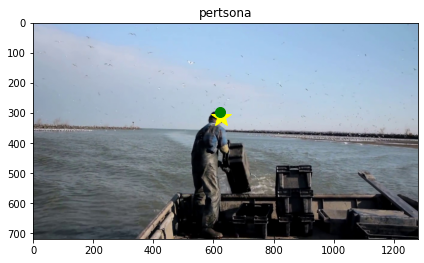

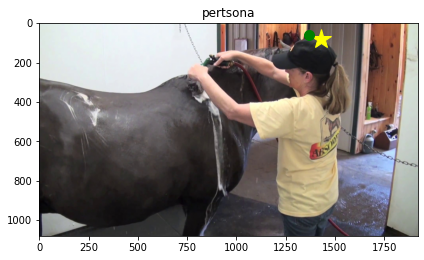

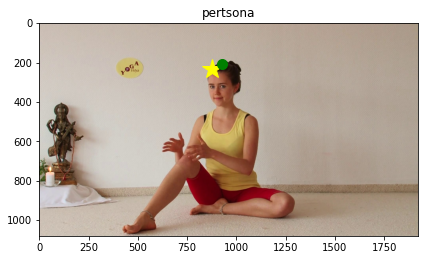

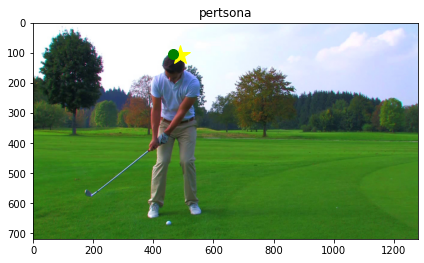

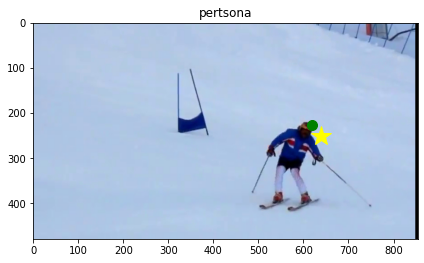

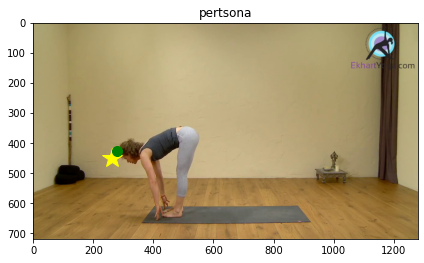

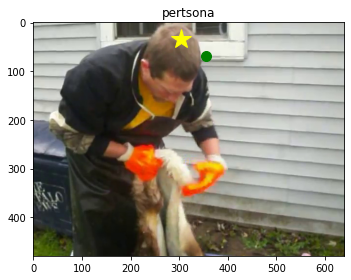

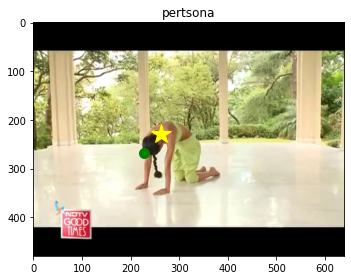

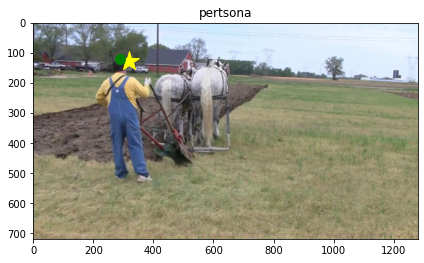

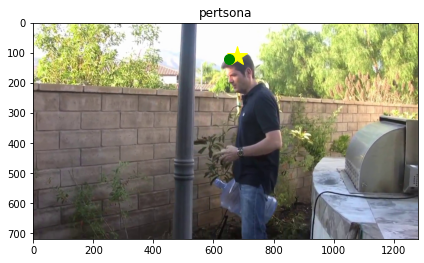

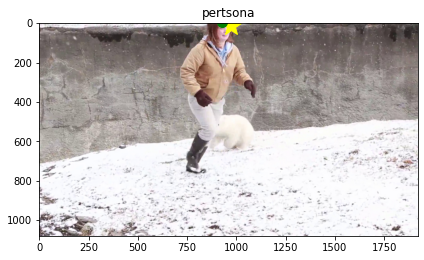

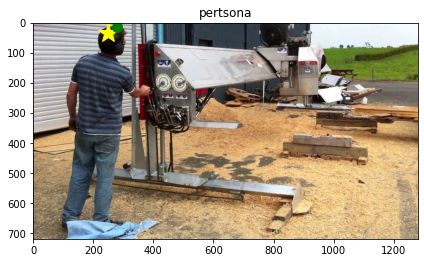

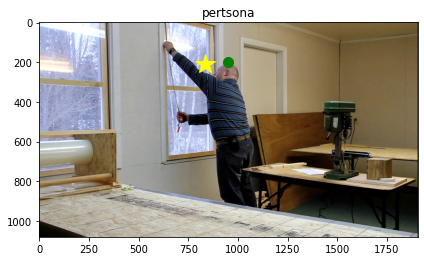

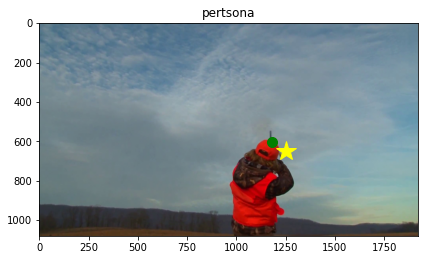

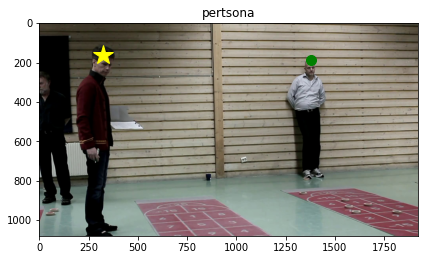

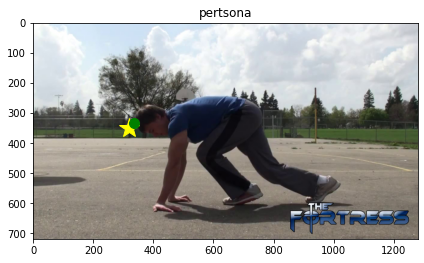

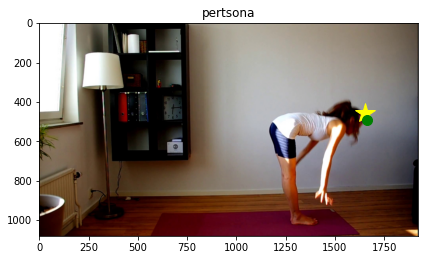

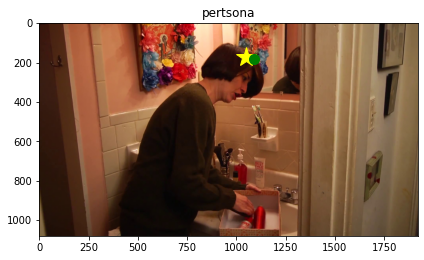

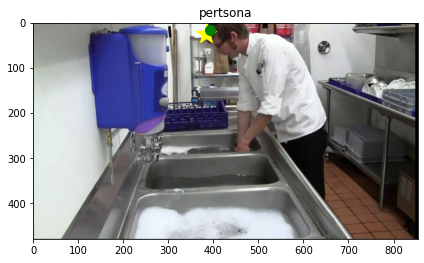

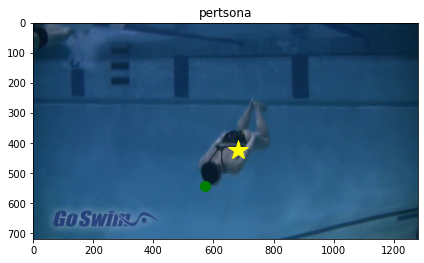

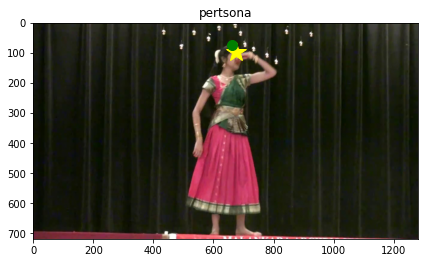

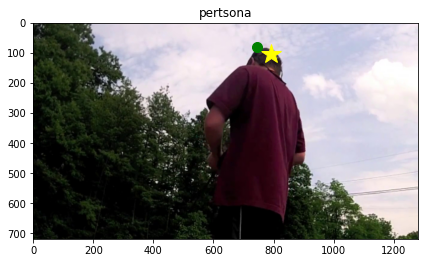

KeyboardInterrupt: ignored

In [ ]:
for i in range(len(test_x)):
  nombre= test_dataframe.iloc[i]["Argazkia"]
  nombre = "/content/content/test/" + nombre 
  irudi = imread(nombre)
  luzera = irudi.shape
  x = test_x[i]*luzera[1]/test_dataset.labeltransform
  y = test_y[i]*luzera[0]/test_dataset.labeltransform
  
  labelx = test_dataframe.iloc[i]["x"]
  labely = test_dataframe.iloc[i]["y"]

  plt.plot(x,y, marker='*', ls='none', ms=20, color='yellow')
  plt.plot(labelx,labely, marker='.', ls='none', ms=20, color='green')
  plt.imshow(irudi)
  plt.title('pertsona')
  plt.tight_layout()
  plt.show()